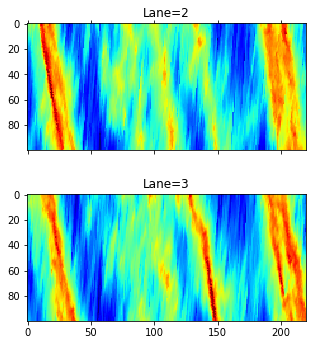

In [3]:
# Using the highD dataset for co-kriging
from functions import *
from scipy.io import loadmat, savemat
path = '..\\data\\HighD_multilane\\'
full3 = loadmat(path+'highD_r3_full.mat')['full_speed']
full3 = fill_nan(full3)
full4 = loadmat(path+'highD_r4_full.mat')['full']
full = [full3, full4]
vmax = max([f.max() for f in full])
vmin = min([f.min() for f in full])

fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1)
for i, ax in enumerate(axes):
    ax.matshow(full[i], cmap='jet_r')
    ax.set_title(f'Lane={i+2}')
axes[-1].xaxis.set_ticks_position('bottom')

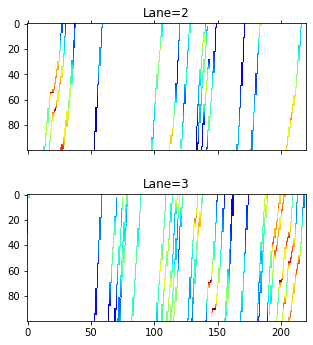

In [4]:
data3 = loadmat(path+'highD_r0.05_lane3_seed0.mat')['s']
data4 = loadmat(path+'highD_r0.05_lane4_seed0.mat')['s']
data = [data3, data4]
od = len(data)  # number of output dimensions
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1)
for i, ax in enumerate(axes):
    ax.matshow(data[i], cmap='jet_r')
    ax.set_title(f'Lane={i+2}')
axes[-1].xaxis.set_ticks_position('bottom')

In [5]:
# ICM
mask = [~np.isnan(d) for d in data]
train_X = [np.where(mask[i] == 1) for i in range(od)]
train_Y = [data[i][train_X[i]].reshape(-1, 1) for i in range(od)]
n_per_lane = [train_Y[i].shape[0] for i in range(od)]
train_X = [np.concatenate([x.reshape([-1, 1]) for x in train_X[i]], axis = 1) for i in range(od)]
train_X_aug = np.vstack(tuple(np.hstack((train_X[i], i*np.ones((n_per_lane[i], 1)))) for i in range(od)))

train_Y_aug = np.vstack(tuple(np.hstack((train_Y[i], i*np.ones((n_per_lane[i], 1)))) for i in range(od)))
mean_Y = np.mean(train_Y_aug[:, 0])
std_Y = np.std(train_Y_aug[:, 0])
train_Y_aug[:, 0]  = (train_Y_aug[:, 0] - mean_Y) / std_Y  # standardize

def optimize_model_with_scipy(model,maxiter=1000, disp=50):
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss,
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": disp, "maxiter": maxiter},
    )

base_kernel = Directional_Kernel(Rational_Quadratic, lengthscales=[60.0, 13.0], theta=0.10, variance=0.2, alpha=10.0)
coreg = gpflow.kernels.Coregion(output_dim=od, rank=2, active_dims=[2])
kernel = base_kernel * coreg
lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.Gaussian(variance=0.2)]*od)
model = gpflow.models.VGP(kernel=kernel, likelihood=lik, data=(train_X_aug, train_Y_aug))
# print_summary(model)
optimize_model_with_scipy(model, maxiter=1500, disp=50)


2023-02-20 05:21:02.033224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 05:21:02.036053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 05:21:02.037037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 05:21:02.038220: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      9088727     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33154D+04    |proj g|=  9.69571D+03

At iterate   50    f=  2.24100D+03    |proj g|=  1.25340D+02

At iterate  100    f=  1.51652D+03    |proj g|=  2.30292D+02

At iterate  150    f=  1.03829D+03    |proj g|=  1.66692D+02

At iterate  200    f=  7.09539D+02    |proj g|=  1.54125D+02

At iterate  250    f=  4.29182D+02    |proj g|=  1.58368D+02

At iterate  300    f=  2.33862D+02    |proj g|=  3.84075D+02

At iterate  350    f=  8.53404D+01    |proj g|=  3.26144D+02

At iterate  400    f= -5.08388D+01    |proj g|=  3.64282D+02

At iterate  450    f= -1.64607D+02    |proj g|=  1.83996D+01

At iterate  500    f= -2.67063D+02    |proj g|=  2.26090D+02

At iterate  550    f= -3.49568D+02    |proj g|=  2.27497D+02

At iterate  600    f= -4.40390D+02    |proj g|=  1.84406D+02

At iterate  650    f= -5.4

In [6]:
predicted_Y = []
for i in range(od):
    test_X = np.where(full[i] >= -10000)
    test_X = np.concatenate([x.reshape([-1, 1]) for x in test_X], axis=1)
    test_X = test_X.astype(np.float64)
    test_X = np.hstack((test_X, i*np.ones((test_X.shape[0], 1))))
    predicted_Y.append(model.predict_f(test_X, full_cov=False)[0].numpy().reshape(full[i].shape) * std_Y + mean_Y)

Lane0, test mae2: 5.016, rmse2: 6.821.
Lane1, test mae2: 5.089, rmse2: 6.950.


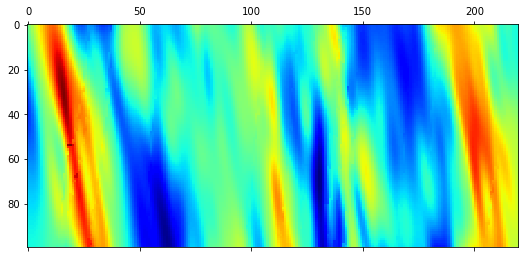

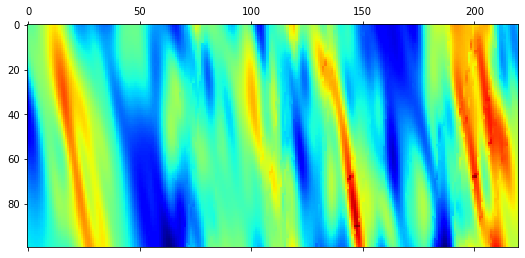

In [7]:
predicted_Y2 = predicted_Y.copy()  # The prediction with observed location unchanged
for i in range(od):
    predicted_Y2[i][mask[i]] = data[i][mask[i]]
    test_mae2 = mae(predicted_Y2[i], full[i])
    test_rmse2 = rmse(predicted_Y2[i], full[i])
    print(f'Lane{i}, test mae2: {test_mae2:.3f}, rmse2: {test_rmse2:.3f}.')
    plt.matshow(predicted_Y2[i], cmap='jet_r')


# print(f'{test_name}. theta: {model.kernel.theta.numpy():.3f}, n:{n},'
#       f'lengthscale: {model.kernel.lengthscale.numpy()}, likelihood: {model.likelihood.variance.numpy()}, time: {time.time()-time0:.3f}')
# print(f'Train mae: {train_mae:.3f}, rmse: {train_rmse:.3f}. Test mae: {test_mae:.3f}, rmse: {test_rmse:.3f}. '
#       f'Test mae2: {test_mae2:.3f}, rmse2: {test_rmse2:.3f}.')

# Save the model
save_pickle(gpflow.utilities.parameter_dict(model), f'./model.pkl')
savemat('./predict.mat',{'y3':predicted_Y2[0], 'y4':predicted_Y2[1]},do_compression=True)